In [13]:
import sys
sys.path.insert(0, "../")

import os
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from tqdm import tqdm

from peakfitting.peaks import find_local_peaks

ModuleNotFoundError: No module named 'tqdm'

## Load data

In [4]:
data_dir = "../simulation_data/test_params_MoS2_layers_8-test/fitting_parameters/"

data = np.load(data_dir+"sigmas.npz", allow_pickle=True)

gt = data['gt']
pred = data['pred']
temp = data['temp']
N = temp.shape[0]

## Separate in low and high $\sigma$

In [5]:
gt_separate = np.empty(shape=(2, N))
for n in range(N):
    mu = gt[n].mean()
    gt_separate[0, n] = gt[n][gt[n] <= mu].mean()   # low
    gt_separate[0, n] = gt[n][gt[n] > mu].mean()    # high

## Get systems with low and high temperature

In [6]:
temperature_min = np.sort(temp)[:4]
temperature_max = np.sort(temp)[-5:-1]
system_temp_min = np.asarray(np.where(np.in1d(temp, temperature_min))).squeeze()
system_temp_max = np.asarray(np.where(np.in1d(temp, temperature_max))).squeeze()


param_dir = "../simulation_data/test_params_MoS2_layers_8-test"
with open(os.path.join(param_dir, "parameters.json"), "r") as file:
    TEM_inital = json.load(file)
    
for key in TEM_inital:
    if "_size" in key:
        print(key)
        print(TEM_inital[key], end="\n\n")

image_size
[640, 640]

wave_size
[1600, 1600]



In [7]:
image_size = TEM_inital['image_size']

waves_temp_min = np.empty(
    shape=(0, *image_size, 2)
)
waves_temp_max = waves_temp_min.copy()

for i, (image_temp_min, image_temp_max) in enumerate(zip(system_temp_min, system_temp_max)):
    imagenumber = "{:04d}".format(image_temp_min)
    print("Low temperature system:\t {:}".format(imagenumber))
    TEM_params = np.load(os.path.join(param_dir, "images_labels", "image_label_000_"+imagenumber+".npz"))
    waves_temp_min = np.concatenate((waves_temp_min, TEM_params['label']), axis=0,)
    
    imagenumber = "{0:04d}".format(image_temp_max)
    print("High temperature system: {}".format(imagenumber))
    TEM_params = np.load(os.path.join(param_dir, "images_labels", "image_label_000_"+imagenumber+".npz"))
    waves_temp_max = np.concatenate((waves_temp_max, TEM_params['label']), 
                                    axis=0)

Low temperature system:	 0408
High temperature system: 0128
Low temperature system:	 0780
High temperature system: 0358
Low temperature system:	 0921
High temperature system: 0454
Low temperature system:	 0948
High temperature system: 0542


In [8]:
imaginary_temp_min = waves_temp_min[..., 1]
imaginary_temp_max = waves_temp_max[..., 1]

In [9]:
OFFSET = 6
def get_peaks(image):
    r'''
    Get peaks from method find_local_peaks()
    
    Parameters
    ----------
        ``image``: An array of size (M, N)
    
    Returns
    -------
        ``peaks``: An array of size (K, 2) of the (x,y) positions of the peaks as integers.
    
    '''
    peaks = find_local_peaks(image, 
                            threshold=0.3, 
                            min_distance=10, 
                            exclude_border=0,
                            exclude_adjacent=True)
    
    return peaks.astype(int).squeeze()

def get_image(image, peak, OFFSET):
    '''
    Get a ``sub_image`` of ``image`` around the ``peak``.
    
    Parameters
    ----------
        ``image``: The image of the whole system.
        ``peak``: The position of the peak to be analysed. A list of utple of (x,y)-coordinates.
        
    Returns
    -------
        ``sub_image``: An image centered around the ``peak``.
        ``peak``: The peak input peak.
    '''
    
    peak = peak.astype(int)
    im = image[peak[0]-OFFSET:peak[0]+OFFSET, peak[1]-OFFSET:peak[1]+OFFSET]
    return im

In [10]:
def refine_peaks(sub_image):
    '''
    Get refined peak position in sub_image, using a gaussian-fit.
    
    Parameters
    ----------
        ``sub_image``: The input image; a sub_image centered around a peak.T
        
    Returns
    -------
        ``popt``: The parameters optimized using least squares.
        ``message``: A message describing the concergence of the leas_squares() method.    
    '''
    
    x, y = np.indices(sub_image.shape)
    
    x = x.ravel()
    y = y.ravel()
    z = sub_image.ravel()
    
    def residuals(p):
        # x0, y0, z0, A, a = p
        
        return gauss(x, y, *p) - z
    
    
    initial = np.array([6, 6, z.min(), z.max() - z.min(), 3])
    
    size = np.sqrt(len(z))
    
    lower_z = -0.7
    upper_z = 0.7
    bounds = [(-size, -size, lower_z,      0,      0),
              ( size,  size, upper_z, np.inf, np.inf)]
    
    ls = least_squares(residuals, initial, bounds=bounds)
    # print(ls.cost)
    return ls.x, ls.message

def gauss(x, y, *params):
    '''
    The gaussian of which to fit the parameters.
    
    Parameters
    ----------
        ``x``: A ndarray of shape (N,1)
        ``y``: A ndarray of shape (N,1)
        ``*Params``: A tuple of ``5`` parameters corresponding to the values of: ``x0``, ``y0``, ``z0``, ``Amplitude``, ``a = 1/(2*sigma**2)``
    
    Returns
    -------
        ``out``: A ndarray of shape (N,1) of the corresponding fit values.
    '''
    x0, y0, z0, A, a = params
    
    # exponent = -1/2 * ( (x - x0)**2 + (y - y0)**2)/a**2
    exponent = -a * ( (x - x0)**2 + (y - y0)**2 )
    return z0 + A*np.exp(exponent)

def get_parameters(sub_image, plot=False):
    
    '''
    Determine parameters of a fit for a specific sub_image
    '''
    
    popt, message = refine_peaks(sub_image)
    x0, y0, z0, A, a = popt
    
    sub_peak = get_peaks(sub_image)
    sigma = np.sqrt(1/(2*a))
    # popt = x0, y0, z0, A, sigma
    
    N, M = sub_image.shape
    x_range = np.arange(N)
    if plot:
        Z = sub_image[:, sub_peak[1]]
        
        xs = np.linspace(0, N, 100)
        fit = gauss(xs, y0, *popt)
        
        plt.plot(xs, fit, '--r')
        plt.plot(x_range, Z, 'ob')
        plt.legend(["Fit", "data-points"])
        plt.show()
    
    return (x0, y0, z0, A, sigma)



###########################################
###########################################
ref_p = []
z = []
A = []
sigmas = []
system = imaginary_temp_max[0]
OFFSET = 6
peaks = get_peaks(system)
for p in tqdm(peaks):
    if np.any(p < OFFSET) or np.any(p > system.shape[0] - OFFSET):
        continue
    sub_image = get_image(system, p, OFFSET=OFFSET)
    sub_peak = get_peaks(sub_image)
    popt = get_parameters(sub_image, plot=False)
    
    ref_p.append([popt[0] - OFFSET + p[0], popt[1] - OFFSET + p[1]])
    z.append(popt[2])
    A.append(popt[3])
    sigmas.append(popt[4])

ref_p = np.asarray(ref_p)
z = np.asarray(z)
A = np.asarray(A)
sigmas = np.asarray(sigmas)

NameError: name 'find_local_peaks' is not defined

In [33]:
# p = peaks[221]
# sub_image = get_image(system, p, OFFSET=6)
# sub_peak = get_peaks(sub_image)
# _ = get_parameters(sub_image, plot=True)

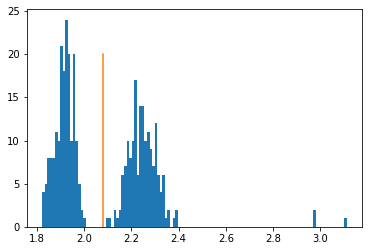

In [55]:
plt.hist(sigmas, bins=len(sigmas)//3)
mu = sigmas.mean()
plt.plot([mu]*2, [0,20])
plt.show()

In [7]:
def abc():

    a, b, c, d = 1,2,3,4
    m = "test"
    return (a,b,c,d), m

*popt, m = abc()

popt

[1, 2, 3, 4]